In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [7]:
class LatentFunction(gpytorch.GridInducingPointModule):
    def __init__(self):
        super(LatentFunction, self).__init__(grid_size=20, grid_bounds=[(0, 1), (0, 1)])
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

class GPRegressionModel(gpytorch.GPModel):
    def __init__(self):
        super(GPRegressionModel,self).__init__(GaussianLikelihood())
        self.latent_function = LatentFunction()
        
    def forward(self, x):
        return self.latent_function(x)
    
model = GPRegressionModel()

In [8]:
def plot_model_and_predictions(model):
    n = 10
    test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
    for i in range(n):
        for j in range(n):
            test_x.data[i * n + j][0] = float(i) / (n-1)
            test_x.data[i * n + j][1] = float(j) / (n-1)

    observed_pred = model(test_x)
    pred_labels = observed_pred.mean().view(n, n).data.numpy()
    
    test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
    delta_y = numpy.absolute(pred_labels - test_y_actual)
    
    def ax_plot(f, ax, y_labels, title):
        im = ax.imshow(y_labels)
        ax.set_title(title)
        f.colorbar(im)
    
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
    
    f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

    f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
    ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')
    
    return f

In [9]:
# Optimize the model
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.1)
optimizer.n_iter = 0
for i in range(60):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -model.marginal_log_likelihood(output, train_y)
    loss.backward()
    optimizer.n_iter += 1
    print('Iter %d/60 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

_ = model.eval()

Iter 1/60 - Loss: 1725.539
Iter 2/60 - Loss: 1645.503
Iter 3/60 - Loss: 1568.839
Iter 4/60 - Loss: 1492.605
Iter 5/60 - Loss: 1412.380
Iter 6/60 - Loss: 1328.061
Iter 7/60 - Loss: 1246.100
Iter 8/60 - Loss: 1146.549
Iter 9/60 - Loss: 1038.561
Iter 10/60 - Loss: 910.670
Iter 11/60 - Loss: 806.377
Iter 12/60 - Loss: 699.642
Iter 13/60 - Loss: 595.665
Iter 14/60 - Loss: 497.513
Iter 15/60 - Loss: 420.571
Iter 16/60 - Loss: 347.139
Iter 17/60 - Loss: 249.666
Iter 18/60 - Loss: 180.042
Iter 19/60 - Loss: 97.575
Iter 20/60 - Loss: 20.142
Iter 21/60 - Loss: -52.561
Iter 22/60 - Loss: -119.171
Iter 23/60 - Loss: -191.274
Iter 24/60 - Loss: -235.056
Iter 25/60 - Loss: -314.924
Iter 26/60 - Loss: -327.982
Iter 27/60 - Loss: -365.891
Iter 28/60 - Loss: -410.905
Iter 29/60 - Loss: -443.720
Iter 30/60 - Loss: -438.949
Iter 31/60 - Loss: -435.717
Iter 32/60 - Loss: -474.906
Iter 33/60 - Loss: -441.107
Iter 34/60 - Loss: -363.770
Iter 35/60 - Loss: -350.626
Iter 36/60 - Loss: -355.465
Iter 37/60 - Lo

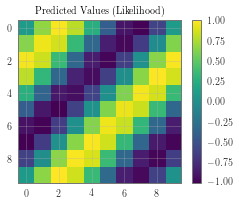

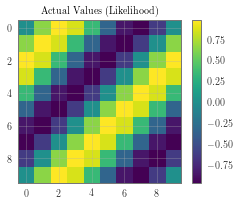

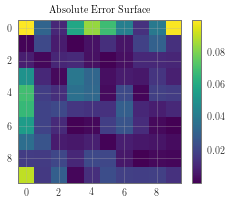

In [10]:
model.condition(train_x, train_y)
f = plot_model_and_predictions(model)